<a href="https://colab.research.google.com/github/saquibali7/Image_Segmentation/blob/main/task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import save_image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/Data_Embryo_Mask'
files = os.listdir(path)
print(len(files))

3668


In [5]:
print(files[3009])

Mask_4.jpg


In [6]:
def file_no(file_name):
  file_type = file_name.split("_")
  file_n = file_type[0]
  file_no = file_type[1].split(".")
  file_number = file_no[0]
  return file_number

In [38]:
def img_arr(path, file_name):
  img = Image.open(os.path.join(path,file_name))
  img = np.array(img)/255.0
  print(img.shape)
  return img


(500, 500, 4)
(500, 500, 3)


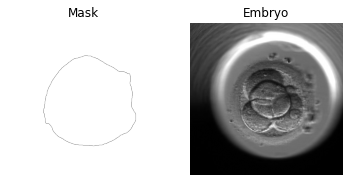

In [43]:
ix = randint(0, len(files))
file_name = files[ix]
n=file_no(file_name)
if(file_name[0]=='M'):
  mask_img = img_arr(path,file_name)
  plt.subplot(1,2,1)
  plt.imshow(mask_img)
  plt.axis("off")  
  plt.title("Mask")
  plt.subplot(1,2,2)
  emb_img = img_arr(path,'Embryo_'+n+'.jpg')
  plt.imshow(emb_img)
  plt.title("Embryo")
  plt.axis("off")  
else :
  emb_img = img_arr(path, file_name)
  plt.subplot(1,2,1)
  plt.imshow(emb_img)
  plt.title("Embryo")
  plt.axis("off")  
  plt.subplot(1,2,2)
  mask_img = img_arr(path,'Mask_'+n+'.jpg')
  plt.imshow(mask_img)
  plt.title("Mask")
  plt.axis("off") 




In [ ]:
X = []
Y = []

for file in files:
  if(file[0]=='M'):
    continue
  else :
    try:
      img = Image.open(os.path.join(path, file))
      emb_img =  img_arr(path, file)
      n = file_no(file)
      mask_img = img_arr(path, 'Mask_'+n+'.jpg')
      X.append(emb_img)
      Y.append(mask_img)
    except:
      print("Image not opened!!")
    
    

Image not opened!!


## UNET MODEL

In [21]:
class CNNBlocks(nn.Module):
  def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super(CNNBlocks, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2),
    )

    self.use_dropout= use_dropout
    self.dropout = nn.Dropout(0.5)
    self.down = down

  def forward(self, x):
      x = self.conv(x)
      return self.dropout(x) if self.use_dropout else x

In [25]:
class Generator(nn.Module):
  def __init__(self, in_channels, features=64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )

    self.down1 = CNNBlocks(features, features*2, down=True, act="leaky", use_dropout=False)
    self.down2 = CNNBlocks(features*2, features*4, down=True, act="leaky", use_dropout=False)
    self.down3 = CNNBlocks(features*4, features*8, down=True, act="leaky", use_dropout=False)
    self.down4 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down5 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down6 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, 4, 2, 1),
        nn.ReLU(),
    )

    self.up1 = CNNBlocks(features*8, features*8, down=False, act="relu", use_dropout=True)
    self.up2 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up3 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up4 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=False)
    self.up5 = CNNBlocks(features*8*2, features*4, down=False, act="relu", use_dropout=False)
    self.up6 = CNNBlocks(features*4*2, features*2, down=False, act="relu", use_dropout=False)
    self.up7 = CNNBlocks(features*2*2, features, down=False, act="relu", use_dropout=False)
    self.finalup = nn.Sequential(
        nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
        nn.Tanh(),
    )

  def forward(self , x):
      d1 = self.initial_down(x)
      d2 = self.down1(d1)
      d3 = self.down2(d2)
      d4 = self.down3(d3)
      d5 = self.down4(d4)
      d6 = self.down5(d5)
      d7 = self.down6(d6)
      bottleneck = self.bottleneck(d7)
      up1 = self.up1(bottleneck)
      up2 = self.up2(torch.cat([up1,d7], 1))
      up3 = self.up3(torch.cat([up2,d6], 1))
      up4 = self.up4(torch.cat([up3,d5], 1))
      up5 = self.up5(torch.cat([up4,d4], 1))
      up6 = self.up6(torch.cat([up5,d3], 1))
      up7 = self.up7(torch.cat([up6,d2], 1))
      return self.finalup(torch.cat([up7, d1], 1))

In [28]:
in_channels = 3
features = 64
gen = Generator(in_channels = in_channels, features=features)
x= torch.rand((1,3,256,256))
out = gen(x)
print(x.shape)

torch.Size([1, 3, 256, 256])


In [29]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [44]:
class ImageDataset(Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.files = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    img_file = self.files[index]
    if(img_file[0]=='E'):
      try:
        img = Image.open(os.path.join(self.root_path, img_file))
        emb_img =  img_arr(path, file)
        n = file_no(file)
        mask_img = img_arr(path, 'Mask_'+n+'.jpg')
        return emb_img, mask_img
      except:
        print("Error!")
        


In [32]:
dataset = ImageDataset(path)
loader = DataLoader(dataset, batch_size = 16)


In [ ]:
for idx, (x, y) in enumerate(loader):
  plt.subplot(1, 2, 1)
  plt.imshow(x[0])
  plt.subplot(1, 2, 2)
  plt.inshow(y[0])
  break